## Vector Error Correction Model ( 벡터오차수정모형)

   - 단위근 검정
   - 차수 설정
   - 공적분 검정 
   - 장기모형 설정
   - VECM 모형 설정 
   - 인과관계 검정 
   - 충격반응분석
   - 예측

In [1]:
import os

import pandas as pd
import numpy as np
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')


import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR,VECM
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('수출금액_최종.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
#data.dtypes

#data.dtypes --> float type 확인
data['한국수출금액_USD'] = (data['한국수출금액_USD'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['화물수송총괄'] = (data['화물수송총괄'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['코스피지수'] = (data['코스피지수'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['코스닥지수'] = (data['코스닥지수'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['환율'] = (data['환율'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['부산항수출금액_1000달러'] = (data['부산항수출금액_1000달러'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['부산항수입금액_1000달러'] = (data['부산항수입금액_1000달러'].str.split()).apply(lambda x: float(x[0].replace(',', '')))

(264, 22)


### 단위근 검정
 - H0 : 비정상 시계열 
 - H1 : 정상 시계열

In [5]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'   ADF 검정 : "{name}"', "\n   ", '-'*47)
    print(f' H0 : 단위근 존재 --> 비정상 시계열.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. H0 기각")
        print(f" => 정상 시계열 .")
    else:
        print(f" => P-Value = {p_value}. H0 채택")
        print(f" => 비정상 시계열")
        
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)
    print()

   ADF 검정 : "한국수출금액_USD" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -0.9662
 => P-Value = 0.7654. H0 채택
 => 비정상 시계열

   ADF 검정 : "한국수입금액_USD" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -0.7802
 => P-Value = 0.8249. H0 채택
 => 비정상 시계열

   ADF 검정 : "경기종합지수" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = 2.7759
 => P-Value = 1.0. H0 채택
 => 비정상 시계열

   ADF 검정 : "수출물가지수" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -2.8106
 => P-Value = 0.0568. H0 채택
 => 비정상 시계열

   ADF 검정 : "수입물가지수" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -2.0314
 => P-Value = 0.2

In [6]:
# 유의수준 1%기준까지 확장하여 정상시계열 변수 제거 
data = data.drop(['수출물가지수','환율','실업률','수출물가등락률','무역경기확산지수'],axis=1) 

In [7]:
data.shape

(264, 17)

### VECM 차수 설정

In [8]:
df = data

In [9]:
import warnings 
warnings.filterwarnings(action='ignore')

In [10]:
model = vecm.select_order(df, maxlags=3)
model.summary()

,AIC,BIC,FPE,HQIC
0,244.9,249.1*,2.218e+106,246.6*
1,243.7,251.9,7.296e+105,247.0
2,243.3,255.4,5.272e+105,248.2
3,243.0*,259.0,4.098e+105*,249.4


### 공적분 검정 ( Johansen Cointegration Test)
   - H0 : 공적분 존재 X --> VAR
   - H1 : 공적분 존재 O --> VECM(장기적 균형관계 성립) [ Trace, Eigen]

In [11]:
rank_test = select_coint_rank(df, 1, 1, method="trace",signif=0.05)
rank_test.rank # Trace 

7

In [12]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,17,1320.,nan
1,17,1059.,nan
2,17,814.1,nan
3,17,654.4,nan
4,17,518.8,nan
5,17,399.1,358.7
6,17,321.1,306.9
7,17,248.8,259.0


In [13]:
rank_test = select_coint_rank(df, 1, 1, method="maxeig",signif=0.05)
rank_test.rank # Eigen

5

In [14]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,1,261.0,nan
1,2,245.4,nan
2,3,159.6,nan
3,4,135.6,nan
4,5,119.7,nan
5,6,77.93,79.99


### 장기 모형 설정 ( 공적분 검정 결과  & 논문 근거로 시행)

In [15]:
log_data = np.log1p(df)

In [16]:
result = smf.ols('한국수출금액_USD ~ 한국수입금액_USD + 경기종합지수 + 수입물가지수 + 화물수송총괄 + 코스피지수 + 코스닥지수 + Dubai + 다우존스지수 + 나스닥지수 + 한국소비자물가지수 + 미국생산자물가지수 + 전산업생산지수 + 부산항수출금액_1000달러 + 부산항수입금액_1000달러 + 반도체수출금액현황 + 수출단가지수',data=log_data).fit(cov_type='HAC',cov_kwds={'maxlags':1},use_t=True)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             한국수출금액_USD   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     5192.
Date:                Thu, 30 Jun 2022   Prob (F-statistic):          6.49e-302
Time:                        15:22:06   Log-Likelihood:                 544.64
No. Observations:                 264   AIC:                            -1055.
Df Residuals:                     247   BIC:                            -994.5
Df Model:                          16                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.6788      0.695      8.166      0.000       4.309       7.048
한국수입금액_USD         0.3663      0.053      6.904      0.000       0.262       0.471
경기종합지수            -0.9212      0.172     -5.368      0.000      -1.259      -0.583
수입물가지수            -0.3943      0.103     -3.831      0.000      -0.597      -0.192
화물수송총괄             0.0025      0.004      0.562      0.575      -0.006       0.011
코스피지수              0.2878      0.025     11.553      0.000       0.239       0.337
코스닥지수             -0.1386      0.016     -8.761      0.000      -0.170      -0.107
Dubai              0.0515      0.030      1.716      0.087      -0.008       0.111
다우존스지수            -0.2321      0.041     -5.658      0.000      -0.313      -0.151
나스닥지수              0.1031      0.027      3.850      0.000       0.050       0.156
한국소비자물가지수          0.8662      0.191      4.545      0.000       0.491       1.242
미국생산자물가지수          0.3684      0.084      4.371      0.000       0.202       0.534
전산업생산지수            0.2422      0.055      4.364      0.000       0.133       0.351
부산항수출금액_1000달러     0.4827      0.047     10.332      0.000       0.391       0.575
부산항수입금액_1000달러    -0.1871      0.028     -6.659      0.000      -0.242      -0.132
반도체수출금액현황          0.1652      0.017      9.651      0.000       0.131       0.199
수출단가지수             0.0949      0.108      0.879      0.380      -0.118       0.307
==============================================================================
Omnibus:                        3.610   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                4.194
Skew:                           0.064   Prob(JB):                        0.123
Kurtosis:                       3.604   Cond. No.                     1.91e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
[2] The condition number is large, 1.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 오차의 정규성, 등분산성, 독립성 검정 

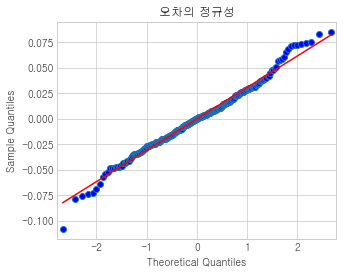

In [17]:
model_residuals = result.resid
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sm.ProbPlot(model_residuals).qqplot(line='s',color='#1f77b4',ax=ax)
ax.title.set_text('오차의 정규성')

[Text(0.5, 0, 'Fitted values'), Text(0, 0.5, 'Residuals')]

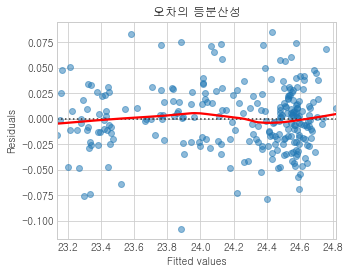

In [18]:
model_fitted_y = result.fittedvalues

fig, ax = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)

sns.residplot(model_fitted_y,log_data['한국수출금액_USD'],data=log_data[['한국수출금액_USD', '한국수입금액_USD', '경기종합지수', '수입물가지수', '화물수송총괄', '코스피지수','코스닥지수', 'Dubai', '다우존스지수', '나스닥지수', '한국소비자물가지수', '미국생산자물가지수','전산업생산지수', '부산항수출금액_1000달러', '부산항수입금액_1000달러', '반도체수출금액현황', '수출단가지수']],lowess=True,scatter_kws={'alpha':0.5},line_kws={'color':'red'},ax=ax)
ax.title.set_text('오차의 등분산성')
ax.set(xlabel='Fitted values',ylabel='Residuals')

Durbin Watson 통계량: 1.9156967757678762


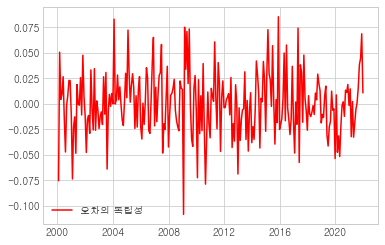

In [19]:
print('Durbin Watson 통계량:',durbin_watson(result.resid))

plt.figure(figsize=(6,4))
plt.plot(result.resid, 'red', label='오차의 독립성')
plt.legend()

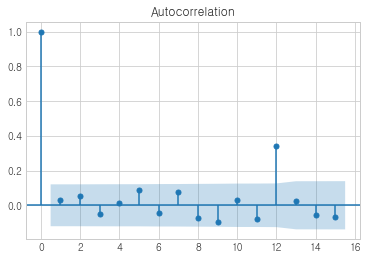

In [20]:
plt.rcParams["figure.figsize"] = (6,4)
acf = smt.graphics.plot_acf(result.resid, lags=15 , alpha=0.05)
acf.show()

### VECM 모형 설정

In [21]:
# add seasonality and the deterministic trend which is 

#    "nc" - no deterministic terms
#    "co" - constant outside the cointegration relation
#    "ci" - constant within the cointegration relation
#    "lo" - linear trend outside the cointegration relation
#    "li" - linear trend within the cointegration relation

In [22]:
model = VECM(df,deterministic='ci', k_ar_diff= 3, coint_rank=6,seasons=4) 
vecm_res = model.fit()
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
season1,2.117e+08,4.46e+08,0.475,0.635,-6.62e+08,1.09e+09
season2,7.21e+08,4.44e+08,1.625,0.104,-1.49e+08,1.59e+09
season3,1.409e+09,4.07e+08,3.462,0.001,6.11e+08,2.21e+09
L1.한국수출금액_USD,-0.6265,0.116,-5.399,0.000,-0.854,-0.399
L1.한국수입금액_USD,-0.3271,0.165,-1.977,0.048,-0.651,-0.003
L1.경기종합지수,1.279e+08,5.98e+08,0.214,0.831,-1.05e+09,1.3e+09
L1.수입물가지수,1.895e+08,1.66e+08,1.141,0.254,-1.36e+08,5.15e+08
L1.화물수송총괄,22.2833,20.567,1.083,0.279,-18.028,62.595
L1.코스피지수,4.619e+06,1.96e+06,2.351,0.019,7.69e+05,8.47e+06
L1.코스닥지수,-8.623e+06,2.82e+06,-3.053,0.002,-1.42e+07,-3.09e+06


#### 오차의 자기상관 확인 --> DW검정

In [23]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(vecm_res.resid)
for col, val in zip(data.columns, out):
    print((col), ':', round(val, 2))

한국수출금액_USD : 2.03
한국수입금액_USD : 2.04
경기종합지수 : 1.88
수입물가지수 : 2.04
화물수송총괄 : 2.11
코스피지수 : 2.07
코스닥지수 : 2.07
Dubai : 2.06
다우존스지수 : 2.0
나스닥지수 : 2.06
한국소비자물가지수 : 2.04
미국생산자물가지수 : 2.06
전산업생산지수 : 2.07
부산항수출금액_1000달러 : 1.97
부산항수입금액_1000달러 : 2.05
반도체수출금액현황 : 1.85
수출단가지수 : 2.0


### VECM 그레인저 인과관계

In [24]:
granger_results = vecm_res.test_granger_causality(causing='한국수입금액_USD',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.330,2.375,0.256,"(4, 2890)"


In [25]:
granger_results = vecm_res.test_granger_causality(causing='한국수입금액_USD',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.330,2.375,0.256,"(4, 2890)"


In [26]:
granger_results = vecm_res.test_granger_causality(causing='경기종합지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.035,2.375,0.387,"(4, 2890)"


In [27]:
granger_results = vecm_res.test_granger_causality(causing='수입물가지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
0.4049,2.375,0.805,"(4, 2890)"


In [28]:
granger_results = vecm_res.test_granger_causality(causing='화물수송총괄',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.003,2.375,0.091,"(4, 2890)"


In [29]:
granger_results = vecm_res.test_granger_causality(causing='코스피지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
4.767,2.375,0.001,"(4, 2890)"


In [30]:
granger_results = vecm_res.test_granger_causality(causing='코스닥지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.420,2.375,0.046,"(4, 2890)"


In [31]:
granger_results = vecm_res.test_granger_causality(causing='Dubai',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
0.3912,2.375,0.815,"(4, 2890)"


In [32]:
granger_results = vecm_res.test_granger_causality(causing='다우존스지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.503,2.375,0.199,"(4, 2890)"


In [33]:
granger_results = vecm_res.test_granger_causality(causing='나스닥지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.227,2.375,0.297,"(4, 2890)"


In [34]:
granger_results = vecm_res.test_granger_causality(causing='한국소비자물가지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
4.394,2.375,0.002,"(4, 2890)"


In [35]:
granger_results = vecm_res.test_granger_causality(causing='미국생산자물가지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
0.7884,2.375,0.533,"(4, 2890)"


In [36]:
granger_results = vecm_res.test_granger_causality(causing='전산업생산지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
10.96,2.375,0.000,"(4, 2890)"


In [37]:
granger_results = vecm_res.test_granger_causality(causing='부산항수출금액_1000달러',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.471,2.375,0.043,"(4, 2890)"


In [38]:
granger_results = vecm_res.test_granger_causality(causing='부산항수입금액_1000달러',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
0.8801,2.375,0.475,"(4, 2890)"


In [39]:
granger_results = vecm_res.test_granger_causality(causing='반도체수출금액현황',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
3.072,2.375,0.015,"(4, 2890)"


In [40]:
granger_results = vecm_res.test_granger_causality(causing='수출단가지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.286,2.375,0.273,"(4, 2890)"


### VECM 충격반응분석

In [41]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

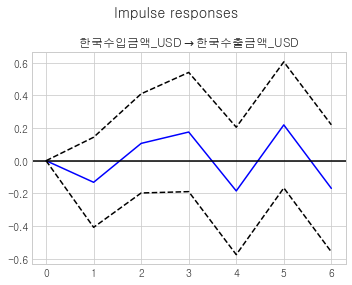

In [42]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='한국수입금액_USD',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

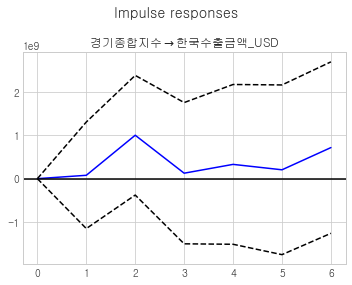

In [43]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='경기종합지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

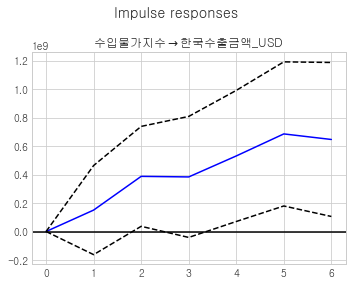

In [44]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='수입물가지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

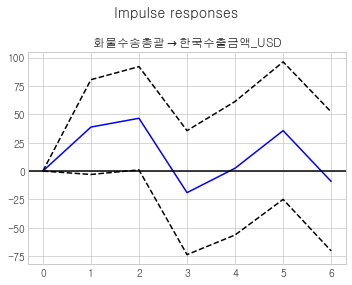

In [45]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='화물수송총괄',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

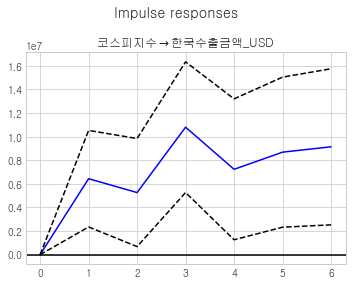

In [46]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='코스피지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

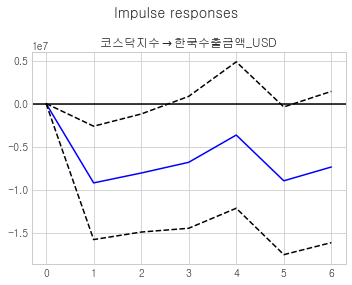

In [47]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='코스닥지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

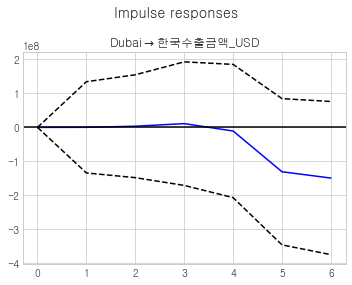

In [48]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='Dubai',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

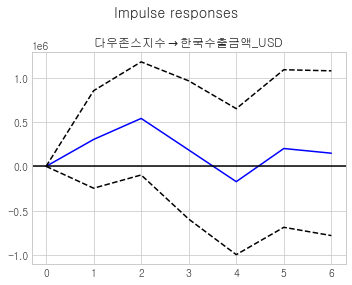

In [49]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='다우존스지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

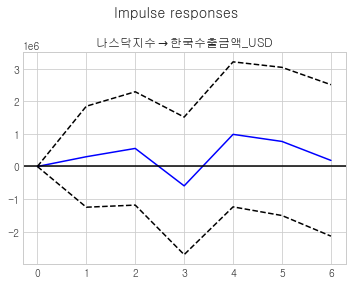

In [50]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='나스닥지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

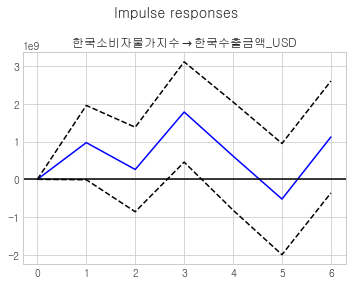

In [51]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='한국소비자물가지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

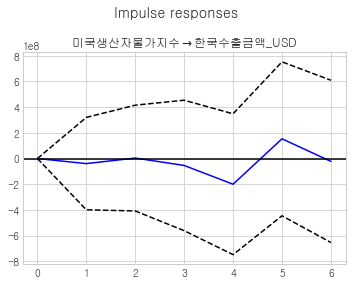

In [52]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='미국생산자물가지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

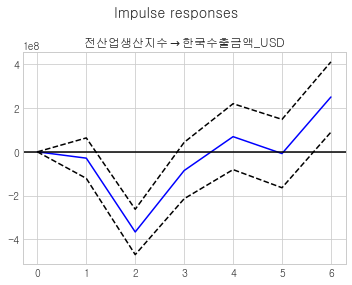

In [53]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='전산업생산지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

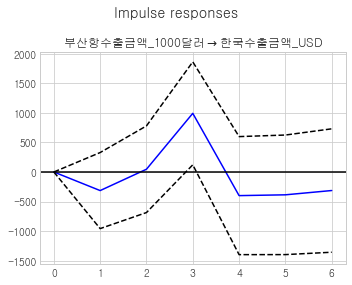

In [54]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='부산항수출금액_1000달러',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

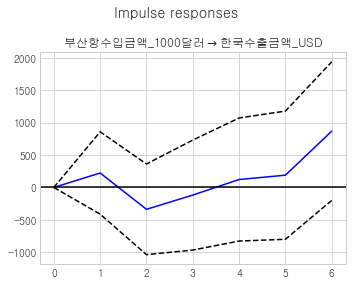

In [55]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='부산항수입금액_1000달러',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

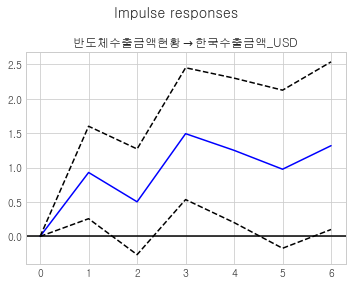

In [56]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='반도체수출금액현황',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

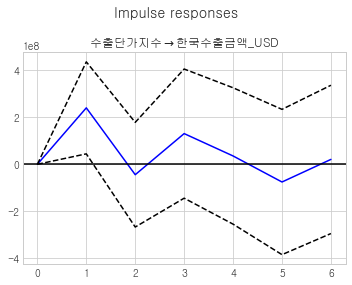

In [57]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='수출단가지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

###  예측값

In [58]:
pd.options.display.float_format = "{:.0f}".format
forecast, lower, upper = vecm_res.predict(6, 0.05)
print("\npoint forecasts:")
print(pd.DataFrame(forecast.round(2)))


point forecasts:
           0           1   2   3         4    5    6   7     8     9   10  11  \
0 55216358824 57642299047 129 120 136418737 2829 1088  70 35779 15689 104 130   
1 54588287638 56007513803 130 119 128260273 2872 1133  69 36446 15938 105 130   
2 60794817355 58956448952 132 118 141355620 3038 1264  66 37360 16435 106 130   
3 57719932325 56667122829 133 120 131315833 3144 1307  69 38022 16740 106 131   
4 60988812437 57418396257 134 121 135096926 3168 1334  72 37990 16857 107 132   
5 63624751402 57910655983 135 122 130540554 3246 1348  74 38441 17129 107 132   

   12       13      14          15  16  
0 111 10790584 6323968 11518625231  96  
1 112 11882151 5623377 11449467305  95  
2 118 13263873 6997745 12266204279  95  
3 111 12463716 6233523 11705132495  95  
4 118 13262014 6555814 12712975652  96  
5 122 13563164 6527394 12982468051  96  


In [59]:
print("lower 95% interval forecasts:")
print(pd.DataFrame(lower.round(2)))

lower 95% interval forecasts:
           0           1   2   3         4    5    6   7     8     9   10  11  \
0 52133131125 55595837253 128 116 126013663 2684 1000  62 34594 15287 104 128   
1 50956586690 53385382813 129 112 115067411 2659 1019  54 34803 15395 104 127   
2 56230824209 55313689256 131 108 125702090 2771 1127  45 35371 15761 105 127   
3 52196966472 51933430619 132 106 113147867 2822 1146  43 35728 15948 106 127   
4 54787128598 51740912923 133 106 114823509 2796 1149  43 35430 15966 106 126   
5 56750924736 51344283728 133 104 108309801 2831 1143  42 35630 16144 106 126   

   12       13      14          15  16  
0 106  9782972 5495770 10912054713  93  
1 107 10768771 4655396 10533789110  90  
2 112 11903188 5811518 11068525020  88  
3 105 10772435 4838629 10269783151  87  
4 111 11354678 5017068 11062920527  86  
5 116 11451366 4828349 11155225456  84  


In [60]:
print("upper 95% interval forecasts:")
print(pd.DataFrame(upper.round(2)))

upper 95% interval forecasts:
           0           1   2   3         4    5    6   7     8     9   10  11  \
0 58299586523 59688760841 129 123 146823811 2973 1175  78 36964 16091 105 131   
1 58219988585 58629644793 131 127 141453135 3085 1247  84 38088 16480 106 132   
2 65358810501 62599208647 133 129 157009150 3305 1401  87 39349 17109 107 134   
3 63242898178 61400815039 134 133 149483799 3467 1468  94 40316 17531 107 135   
4 67190496276 63095879592 136 137 155370343 3539 1519 101 40550 17748 108 137   
5 70498578069 64477028237 137 140 152771307 3661 1552 106 41253 18113 109 138   

   12       13      14          15  16  
0 115 11798197 7152166 12125195749  98  
1 117 12995531 6591358 12365145500  99  
2 124 14624558 8183972 13463883537 101  
3 117 14154996 7628417 13140481838 104  
4 124 15169350 8094561 14363030777 106  
5 129 15674961 8226439 14809710646 107  
